## Part One: Hero Code

-------

Scientists write terrible code. Arguably, most people write terrible code, but our job is to explore and try new thing, so it makes sense that this involves a lot of nasty code. Think "prototype" algorithms, messy data munging and loooots of absolute file paths - **hero code** written during late-night, caffeine fuelled binges, and requiring a superhero (you) to safely use, repurpose, or even run on a different computer. 

This is a problem. While hero code is part of the creative process - it's inevitable when we want to test a new idea or see if something works - writing ONLY hero code wastes time and causes excessive hair loss by:

1. Being generally hard to debug (as complexity increases)
2. Requiring extensive rewriting every time it is used (in different situations)
3. Including it's author as a dependency - if nobody can use your code without your help then either nobody will use it or you'll be bombarded by pleas for help

This last point is important: we all want our work to have impact. Code that runs once can do little more than create a pretty figure; code that can be deployed and run billions of times by many different users can change the world. And if you don't write code that is deployable, then nobody else will - they have better things to do.

----

<img src="https://miro.medium.com/max/480/1*VNh2ihTMppouMBHH5zZlzw.jpeg" width="500px" height="150px">

**<center></center>**

---

To start this mini-tutorial, I've included a typical example of hero-code. It loads a hyperspectral image dataset, applies a principal component analysis (PCA) to reduce it's dimensionality, and then classifies the result using a k-means classifer. While this could be easily done with existing libraries, I've implemented everything from scratch to serve as an example.

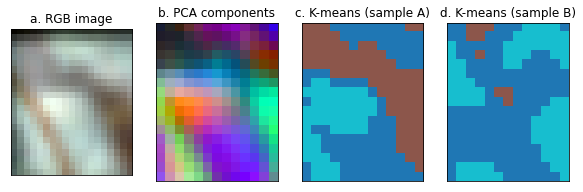

In [247]:
import hylite
from hylite import io
import numpy as np

# load awesome dataset
image = io.load('/Users/thiele67/Documents/notebooks/teaching/Hero_to_Zero/sampleA.hdr')
fig,ax = plt.subplots(1,4,figsize=(10,4))
image.quick_plot(hylite.RGB, rot=True, ax=ax[0])

# not sure what this does exactly, but it seemed like a good idea at the time
X = image.data[3:-3,3:-3,10:-5].reshape((-1,435))
X = X / 10000.

# performance optimisation hack
X = X[::3, : ]

# PCA
mean = np.mean(X, axis=0)
X = X - mean[None, :]
cov = np.dot(X.T, X) / (X.shape[0] - 1) 
eigval, eigvec = np.linalg.eig(cov)
idx = np.argsort(np.abs(eigval))[::-1]
eigvec = eigvec[:, idx]
eigval = np.abs(eigval[idx])
data = image.data[3:-3,3:-3,10:-5] - mean
out = np.zeros((data.shape[0],data.shape[1],3))
for b in range(0, 3):
    out[..., b] = np.dot(data, eigvec[:, b])
pca = hylite.HyImage(out)
pca.quick_plot((0,1,2), rot=True, vmin=2, vmax=98, tscale=True, ax=ax[1])
fig.show()

# classify
np.random.seed(42)
xcentroid = np.random.randint(0,pca.xdim(),3)
ycentroid = np.random.randint(0,pca.ydim(),3)
centroids = np.vstack([xcentroid,ycentroid]).T
centroids = pca.data[centroids[:,0], centroids[:,1],:]
delta = np.array([np.inf, np.inf, np.inf])
while np.max(delta > 0.0001):
    clss = np.argmin( np.linalg.norm( (pca.data[None,:,:,:] - centroids[:,None,None,:]), axis=-1 ), axis=0 )
    means = np.array([np.mean( pca.data[clss==i, :], axis=0) for i in range(3)])
    delta = np.linalg.norm(centroids - means, axis=1 )
    centroids = means
hylite.HyImage(clss[...,None]).quick_plot(0,cmap='tab10',rot=True, ax=ax[2])

# classify another image (using previously "learned" centroids)
image = io.load('/Users/thiele67/Documents/notebooks/teaching/Hero_to_Zero/sampleB.hdr')
data = image.data[3:-3,3:-3,10:-5] - mean
out = np.zeros((data.shape[0],data.shape[1],3))
for b in range(0, 3):
    out[..., b] = np.dot(data, eigvec[:, b])
clss = np.argmin( np.linalg.norm( (out[None,:,:,:] - centroids[:,None,None,:]), axis=-1 ), axis=0 )

hylite.HyImage(clss[...,None]).quick_plot(0,cmap='tab10',rot=True, ax=ax[3])

ax[0].set_title('a. RGB image')
ax[1].set_title('b. PCA components')
ax[2].set_title('c. K-means (sample A)')
ax[3].set_title('d. K-means (sample B)')

fig.show()

#### Exercise

Use the above code to create a set of elbow plots for different numbers of PCA components

## Part two: A better way

As the above exercise should have demonstrated, simple adjustments such as the number of classes or number of PCA dimensions are not easy (and basically require the code to be entirely re-written). Hence, while the code is not wrong (it works!) it is not reusable and basically useless except for the specific task and dataset it was written for.

There are many different (and often conflicting) [design principles](https://www.callicoder.com/software-development-principles/) that can help ensure code is maintainable, durable and reusable. The most important points to keep in mind for this exercise are summarised below.

###### KISS: Keep it simple, stupid
It's very easy to make things far more complex than they need to be. Try and keep software tools focused and as simple as possible.

###### DRY: Don't repeat yourself
Break code into well defined, bit-sized functions rather than repeating (copy + paste is evil!) code. This makes it easier to (1) find and correct bugs, (2) make changes or updates and (3) provides lots of useful components for building new software.

###### Single responsibility principle
Functions should have a single purpose and be organised (into modules) according to their responsibilities

###### Continuous testing
Test always - every block of code should be tested individually during development (in e.g., a notebook environment) and then test functions written to automatically identify issues caused by subsequent changes. 

###### Document everything
Code without documention is unusable. And there are now so many tools for creating and using documentation that there are no excuses either 😉

----------
<img src="https://preview.redd.it/0jelwo9pgcv21.jpg?width=640&crop=smart&auto=webp&s=afc465891e9cd751e8cb866612cff494c60b7a8a">

**<center>Sometimes it is easiest to start from scratch...</center>**

---------

To demonstrate some of the above principals, lets break our "hero code" example into chunks that fit with our design principles. 


#### Exercise

Define a set of functions (no need to implement them) that breaks the above hero code into chunks that conform especially with the KISS and DRY principles. Also write docstrings for these functions following the [google docstrings](https://gist.github.com/redlotus/3bc387c2591e3e908c9b63b97b11d24e) style. If done consistently (from the start of a project!) these can then easily be converted to a friendly website, such as for [hylite](https://hifexplo.github.io/hylite/hylite.html).

In [ ]:
def pca_loadings( data, step=1, ndims=3):
    """
    Compute PCA loadings for the specified dataset.
    
    Args:
     - data (np.ndarray): a numpy array for which the last dimensions contains feature 
                          values (bands) used to compute the PCA.
     - step (int): if greater than one, every nth data point will be used for estimating the 
                   covariance matrix. This can increase performance for big datasets. Default is 1.
     - ndims (int): the number of loading vectors to create. This should equal the number of 
                    dimensions to retain during PCA dimensionality reduction. Default is 3.
                    
    Returns:
     - loadings (np.ndarray): the estimated loadings vectors with shape (data.shape[-1],ndims)
     - mean (float): the mean centering that was used to derive these loadings (and should be used when applying
                         them).
    """
    
    # asserts can help identify problems early
    assert isinstance(data, np.ndarray), "Error: Data must be a numpy array" 
    
    data = data.reshape((-1, data.shape[-1])) # reshape array to a feature vector of shape (npixels,nbands)
    X = data - np.mean(data, axis=0) # mean center the data
    X = X[::step] # only look at a subset of the data, useful for big images
    cov = np.dot(X.T, X) / (X.shape[0] - 1)  # compute covariance matrix
    
    eigval, eigvec = np.linalg.eig(cov) # get eigenvalues of covariance matrix
    idx = np.argsort(np.abs(eigval[:ndims]))[::-1] # sort them into descending order
    eigvec = eigvec[:, idx]
    eigval = np.abs(eigval[idx])
    
    return eigvec, mean 

def apply_loadings( data, loadings, mean=None ):
    """
    Apply loadings to a dataset to derive a dimensionality reduce set of features. Both arguments should be numpy
    arrays. Note that the provided data will be mean-centered first, either using the provided mean or the mean of
    the datasets. Returns a numpy array with the same dimensions as data, except for the last dimension which will
    have one element for every loading vector.
    
    ^^ Note that while this docstring contains the same information as the previous one,
       it is much harder to read!
    """
    # reshape array to a feature vector of shape (npixels,nbands)
    X = data.reshape((-1, data.shape[-1])) 
    
    # do mean centering
    if mean is None:
        mean = np.mean(X, axis=0)
    X = X - mean
    
    # apply loadings
    out = np.zeros(data.shape[:-1]+(loadings.shape[-1],)) # create output array of the correct shape
    for b in range(0, loadings.shape[-1]):
        out[..., b] = np.dot(data, loadings[:, b])
    return out

(435, 3)
(17, 13, 3)


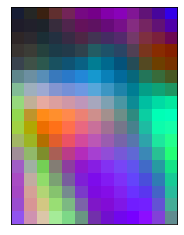

In [285]:
# test code (more on this later!)
image = io.load('/Users/thiele67/Documents/notebooks/teaching/Hero_to_Zero/sampleA.hdr')
image.data = image.data / 10000. # decompress
image.data = image.data[3:-3,3:-3,10:-5] # crop image and remove bad bands

loadings, mean = pca_loadings( image.data, step=3, ndims=3 )
print(loadings.shape)

pca = apply_loadings( image.data, loadings )
print(pca.shape)

fig,ax = hylite.HyImage(pca).quick_plot((0,1,2), vmin=2, vmax=98, 
                                        rot=True, tscale=True, figsize=(4,4)) # and plot for reference
fig.show()

In [297]:
def nearest_neighbour(data, centroids):
    """
    Apply a nearest neighbour classifier.
    
    Args:
        data (np.ndarray): the data to classify. The last dimension of data must have the same length
                          as the last dimension of centroids.
        centroids (np.ndarray): an (n,ndims) array of n centroids.
     
    Returns:
        class : an array with the same shape as data (except the last dimension) containing class ids.
        distance : an array of the distances to each centroid.
    """
    X = data.reshape((-1, data.shape[-1])) # flatten into feature vector. Notice that I've reused this code
                                              # three times now, so could consider pulling it into its own function!
                                              # (but, for now I won't)
    dist = np.linalg.norm( (X[None,:,:] - centroids[:,None,:]), axis=-1)
    clss = np.argmin( dist, axis=0 )
    return clss.reshape(data.shape[:-1]), dist.reshape(data.shape[:-1] + (centroids.shape[0],))

def kmeans(data, n, seed=42, maxiter=100):
    """
    Find the kmeans centroids (and associated classificaiton) for a dataset
    
    Args:
        data (np.ndarray): the data array to find centroids for. The last dimension of this 
                          should contain the features.
        n (int): the number of classes to extract.
        seed (int): a random seed to use when initialising class centroids. Default is 42, naturally.
        maxiter (int): the maximum number of iterations before throwing an error. Default is 100.
     
    Returns:
        - centroids (np.ndarray): an (n,ndims) array of n centroids.
        - distances (np.ndarray): an array of (feature) distances from each data point/pixel to the nearest centroid.
        - classification (np.ndarray): an array of class ids corresponding to the kmeans classified data.
    """
    
    # get random initial centroids
    np.random.seed(seed)
    X = data.reshape((-1, data.shape[-1])) # flatten into feature vector
    centroids = X[ np.random.choice(X.shape[0], n, replace=False), : ]
    
    # compute k means
    delta = np.array([np.inf, np.inf, np.inf])
    i = 0
    while np.max(delta > 0.0001) and i < maxiter:
        clss,dst = nearest_neighbour( X, centroids )
        means = np.array([np.mean( X[clss==i, :], axis=0) for i in range(n)])
        delta = np.linalg.norm(centroids - means, axis=1 )
        centroids = means
        i += 1
    return centroids, dst.reshape(data.shape[:-1]+(centroids.shape[0],)), clss.reshape(data.shape[:-1])

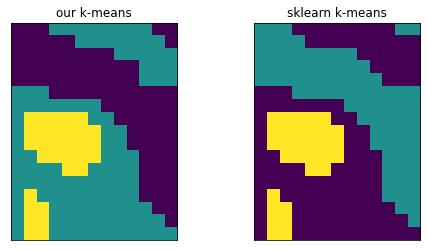

In [298]:
# test code
centroids, dst, clss =  kmeans(pca, 3 )

# plot and compare to sklearn kmeans to check :-)
fig,ax = plt.subplots(1,2,figsize=(8,4))
hylite.HyImage(clss[...,None]).quick_plot(0,rot=True, tscale=True, ax=ax[0])
ax[0].set_title("our k-means")

from sklearn.cluster import KMeans
km = KMeans(3).fit(image.X())
hylite.HyImage( km.labels_.reshape((image.xdim(),image.ydim(),1)) ).quick_plot(0,
                                                                    rot=True, tscale=True, ax=ax[1])
ax[1].set_title("sklearn k-means")
fig.show()

Finally, create a set of elbow plots for different numbers of PCA components (to show that this is now much much easier!) 

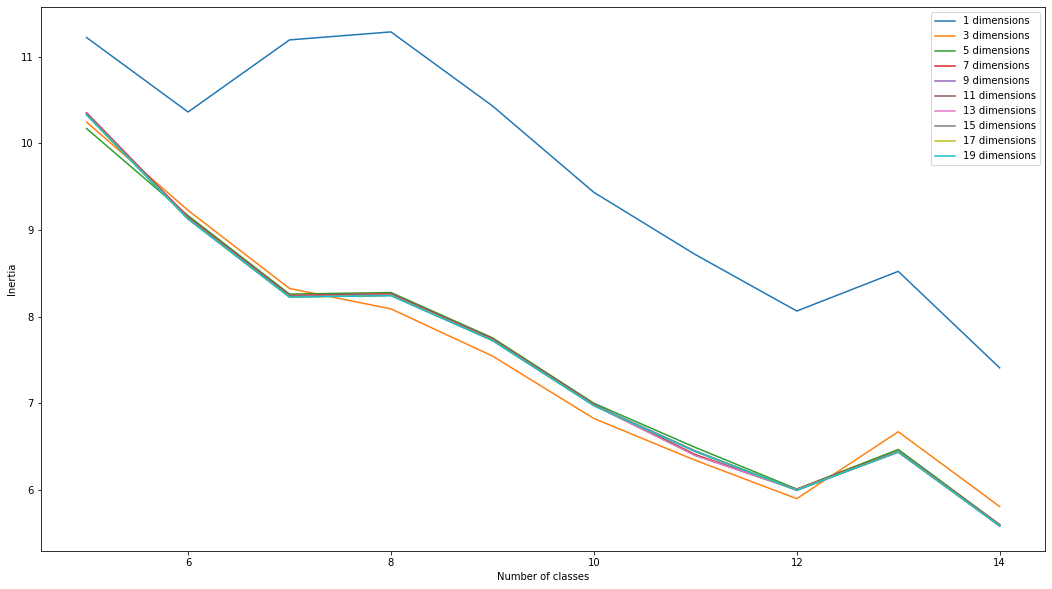

In [322]:
plt.figure(figsize=(18,10))
for dims in range(1,21,2):
    loadings, mean = pca_loadings( image.data, step=3, ndims=dims )
    pca = apply_loadings( image.data, loadings )
    variance=[]
    nclasses = np.arange(5,15)
    for classes in nclasses:
        centroids, dst, clss =  kmeans(pca, classes )
        variance.append( np.var( np.mean(dst,axis=-1) ) )
    plt.plot(nclasses,variance,label='%d dimensions' % dims )
plt.legend()
plt.ylabel("Inertia")
plt.xlabel("Number of classes")
plt.show()

## Part three: Modules and testing

Now that we have our (possibly) working functions, we want to do two things:

(1) Implement them into a python module structure so that they can be imported and (re-)used easily.
(2) Write some test code that can be run automatically to test if later changes will break everything.

----

<img src="http://stfuhero.com.s3-website-us-west-2.amazonaws.com/5a7c22fd38a9c.png">

**<center></center>**

---

To do this we have to move out the jupyter notebook environment (unfortunately), but (fortunately) the 
community of geeks on GitHub can provide a template package we can pull from.


### Part four: Where next with GIT?

- version control
- automatic testing
- build and host documentation websites

-----

<img src="https://miro.medium.com/max/1400/1*B-OPCn67xfe4POnbiJL0Rw.png" width="500px">

**<center></center>**

----------

### Part 5: Conclusions